In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
cuda = torch.device('cuda')
import numpy as np
import matplotlib.pyplot as plt
BATCH_SIZE=40
import random

random.seed(17)
torch.manual_seed(17)
torch.cuda.manual_seed(17)

/home/snake/anaconda3/envs/myenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/snake/anaconda3/envs/myenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#first load datasets
class FontDataset(Dataset):
    def __init__(self, f_name, transform=None):
        self.df = pd.read_csv(f_name)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 1]
        label = self.df.iloc[idx, 2]
        image = Image.open(path).convert('1')
        if self.transform:
            image = self.transform(image)
            image = image.to(cuda)
        sample = (image, label)
        return sample
transformations = transforms.Compose([transforms.ToTensor()])

In [3]:
train_dataset = FontDataset(f_name="train.csv", transform=transformations)
train_dataset_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)

In [4]:
validation_dataset = FontDataset(f_name="validation.csv", transform=transformations)
validation_dataset_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE)

In [5]:
# i didn't use any regulization technique here because we can easily extend our dataset 
# and this is the best regularization we can get
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5,padding=2)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding=2)
        torch.nn.init.xavier_uniform_(self.convtrain_dataset = FontDataset(f_name="train.csv", transform=transformations)
train_dataset_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)2.weight)
        self.fc1 = nn.Linear(3000, 200)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(200, 10)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 3000)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [6]:
def train(model, device, train_loader, optimizer, epoch, test_loader):
    epoch_losses = []
    val_losses = []
    val_accuracies = []
    model.train()
    for i in range(epoch):
        epoch_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        epoch_losses.append(np.mean(epoch_loss))
        print("Overall Epoch %s training loss: %s"%(i, str(np.mean(epoch_loss))))
        val_loss = test(model, device, test_loader)
        val_losses.append(val_loss)
    plt.plot(epoch_losses, label="train_loss", color="red")
    plt.plot(val_losses, label="validation_loss", color="green")
    plt.legend()
    plt.show()
        

def test(model, device, test_loader):
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [7]:
net = Net()
net = net.to(cuda)
#seems regularization does not bring big benefit for the current task
optimizer = optim.Adam(net.parameters())

Overall Epoch 0 training loss: 1.903647307852904

Test set: Average loss: 1.7889, Accuracy: 10829/16000 (68%)

Overall Epoch 1 training loss: 1.7646392386820582

Test set: Average loss: 1.7355, Accuracy: 11644/16000 (73%)

Overall Epoch 2 training loss: 1.7048601324690713

Test set: Average loss: 1.6878, Accuracy: 12392/16000 (77%)

Overall Epoch 3 training loss: 1.6467546715007888

Test set: Average loss: 1.6362, Accuracy: 13201/16000 (83%)

Overall Epoch 4 training loss: 1.627539569106367

Test set: Average loss: 1.6460, Accuracy: 13039/16000 (81%)



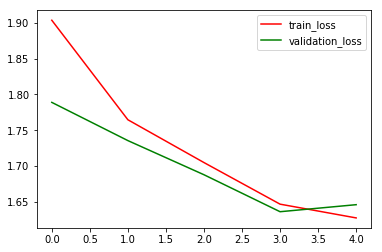

In [8]:
train(net, cuda,train_dataset_loader, optimizer,5, validation_dataset_loader)

Overall Epoch 0 training loss: 1.6173413510786163

Test set: Average loss: 1.6186, Accuracy: 13486/16000 (84%)

Overall Epoch 1 training loss: 1.6062684148550033

Test set: Average loss: 1.6136, Accuracy: 13552/16000 (85%)

Overall Epoch 2 training loss: 1.6003790053394105

Test set: Average loss: 1.6142, Accuracy: 13554/16000 (85%)

Overall Epoch 3 training loss: 1.596035836868816

Test set: Average loss: 1.6199, Accuracy: 13452/16000 (84%)

Overall Epoch 4 training loss: 1.5735012896524536

Test set: Average loss: 1.5715, Accuracy: 14232/16000 (89%)



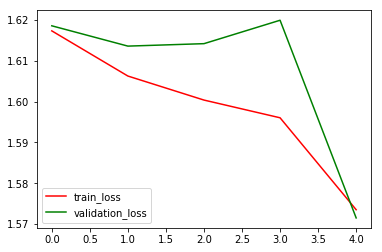

In [9]:
train(net, cuda,train_dataset_loader, optimizer,5, validation_dataset_loader)

Overall Epoch 0 training loss: 1.5376560505893495

Test set: Average loss: 1.5496, Accuracy: 14583/16000 (91%)

Overall Epoch 1 training loss: 1.5200266880459257

Test set: Average loss: 1.5490, Accuracy: 14588/16000 (91%)

Overall Epoch 2 training loss: 1.5136074839366807

Test set: Average loss: 1.5361, Accuracy: 14794/16000 (92%)

Overall Epoch 3 training loss: 1.5068515369958349

Test set: Average loss: 1.5673, Accuracy: 14291/16000 (89%)

Overall Epoch 4 training loss: 1.5039083135790294

Test set: Average loss: 1.5442, Accuracy: 14671/16000 (92%)



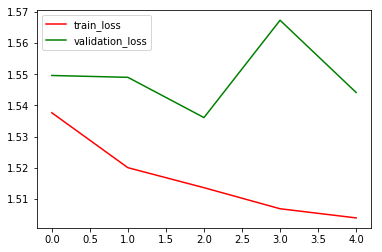

In [10]:
train(net, cuda,train_dataset_loader, optimizer,5, validation_dataset_loader)

Overall Epoch 0 training loss: 1.4877672706047693

Test set: Average loss: 1.5218, Accuracy: 15026/16000 (94%)

Overall Epoch 1 training loss: 1.4839466331733597

Test set: Average loss: 1.5193, Accuracy: 15059/16000 (94%)

Overall Epoch 2 training loss: 1.4815785449412133

Test set: Average loss: 1.5200, Accuracy: 15053/16000 (94%)

Overall Epoch 3 training loss: 1.4800434673494762

Test set: Average loss: 1.5181, Accuracy: 15093/16000 (94%)

Overall Epoch 4 training loss: 1.4790790957212447

Test set: Average loss: 1.5197, Accuracy: 15064/16000 (94%)



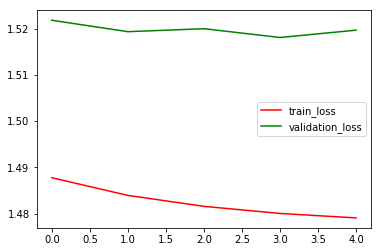

In [11]:
#seems we stuck at plato
#try to tune with very small lr
ft_optimizer = optim.Adam(net.parameters(), lr=0.0001)
train(net, cuda,train_dataset_loader, ft_optimizer,5, validation_dataset_loader)

In [ ]:
#94 is a good score IMO=)
# seems this minima is stable to perturbations so lets proceed with it

In [12]:
def save_checkpoint(model,optimizer, filename="model.pth"):
    state = {"model":model.state_dict(),
             "optimizer":optimizer.state_dict()}
    torch.save(state, filename)

def restore_checkpoint(filename="model.pth"):
    checkpoint = torch.load(filename)
    model = Net()
    model.load_state_dict(checkpoint["model"])
    optimizer = optim.Adam(net.parameters())
    optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

In [13]:
save_checkpoint(net, optimizer)

In [17]:
new_model, optimizer = restore_checkpoint()
new_model.to(cuda)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3000, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [18]:
test_dataset = FontDataset(f_name="test.csv", transform=transformations)
test_dataset_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [19]:
# ensure test score is still good, so model ready for usage
test(new_model, cuda, test_dataset_loader)


Test set: Average loss: 1.5199, Accuracy: 52704/56000 (94%)



1.5199337855066573

In [ ]:
link to the model is here:
https://drive.google.com/open?id=1QIneYwRgF5nhVhxNLJiSIKnrF2eSve84
please upload it to the same folder as notebook location folder